<a href="https://colab.research.google.com/github/raz0208/City-Person-Dataset-EDA/blob/main/CityPerson_LabelFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Augmentation Procsess

In [126]:
# Instal Required Libraries
import os
import zipfile
import json
import pandas as pd
from collections import Counter
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

In [127]:
# Dataset zip files path from Google Drive
gtFine = '/content/drive/MyDrive/CityPersonDataset/gtFine_trainvaltest.zip'
gtFinePanopticParts = '/content/drive/MyDrive/CityPersonDataset/gtFinePanopticParts_trainval.zip'
gtBbox = '/content/drive/MyDrive/CityPersonDataset/gtBbox_cityPersons_trainval.zip'

gtFine_ExtPath = '/content/CityPersonDataset/gtFine_trainvaltest'
gtFinePano_ExtPath = '/content/CityPersonDataset/gtFinePanopticParts_trainval'
gtBbox_ExtPath = '/content/CityPersonDataset/gtBbox_cityPersons_trainval'

In [128]:
# Extracting files function
def extract_zip(file_path, extract_path):
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Extract both datasets zip files
extract_zip(gtFine, gtFine_ExtPath)
extract_zip(gtFinePanopticParts, gtFinePano_ExtPath)
extract_zip(gtBbox, gtBbox_ExtPath)

In [129]:
# List the extracted content from both datasets
gtFine_Files = os.listdir(gtFine_ExtPath)
gtFinepano_Files = os.listdir(gtFinePano_ExtPath)
gtBbox_Files = os.listdir(gtBbox_ExtPath)

gtFine_Files, gtFinepano_Files, gtBbox_Files

(['README', 'gtFine', 'license.txt'],
 ['README_panopticParts.md', 'gtFinePanopticParts', 'license.txt'],
 ['gtBboxCityPersons', 'license.txt', 'README_cityPersons'])

In [130]:
# Path to core folder
gtFine_CorePath = os.path.join(gtFine_ExtPath, 'gtFine')
gtFinePano_CorePath = os.path.join(gtFinePano_ExtPath, 'gtFinePanopticParts')
gtBbox_CorePath = os.path.join(gtBbox_ExtPath, 'gtBboxCityPersons')

# List driectories inside core folders
gtFine_Dirs = os.listdir(gtFine_CorePath) if os.path.exists(gtFine_CorePath) else []
gtFinePano_Dirs = os.listdir(gtFinePano_CorePath) if os.path.exists(gtFinePano_CorePath) else []
gtBbox_Dirs = os.listdir(gtBbox_CorePath) if os.path.exists(gtBbox_CorePath) else []

gtFine_Dirs, gtFinePano_Dirs, gtBbox_Dirs

(['test', 'val', 'train'], ['val', 'train'], ['val', 'train'])

In [131]:
# Define the subdirectories
subdirs = gtFine_Dirs #["train", "val", "test"]

# Initialize dictionaries to store samples from each subdirectory
gtFine_CityFolders = {}
gtFinePano_CityFolders = {}
gtBbox_CityFolders = {}

# Process each subdirectory
for subdir in subdirs:
    gtFine_CityFolders[subdir] = os.listdir(os.path.join(gtFine_CorePath, subdir)) if subdir in gtFine_Dirs else []
    gtFinePano_CityFolders[subdir] = os.listdir(os.path.join(gtFinePano_CorePath, subdir)) if subdir in gtFinePano_Dirs else []
    gtBbox_CityFolders[subdir] = os.listdir(os.path.join(gtBbox_CorePath, subdir)) if subdir in gtBbox_Dirs else []

# Output the first few files for each subdirectory
gtFine_CityFolders_Preview = {key: value[:] for key, value in gtFine_CityFolders.items()}
gtFinePano_CityFolders_Preview = {key: value[:] for key, value in gtFinePano_CityFolders.items()}
gtBbox_CityFolders_Preview = {key: value[:] for key, value in gtBbox_CityFolders.items()}

gtFine_CityFolders_Preview, gtFinePano_CityFolders_Preview, gtBbox_CityFolders_Preview

({'test': ['bielefeld', 'berlin', 'mainz', 'munich', 'bonn', 'leverkusen'],
  'val': ['frankfurt', 'munster', 'lindau'],
  'train': ['tubingen',
   'bremen',
   'strasbourg',
   'hanover',
   'ulm',
   'darmstadt',
   'hamburg',
   'erfurt',
   'jena',
   'stuttgart',
   'dusseldorf',
   'aachen',
   'bochum',
   'zurich',
   'cologne',
   'krefeld',
   'monchengladbach',
   'weimar']},
 {'test': [],
  'val': ['frankfurt', 'munster', 'lindau'],
  'train': ['tubingen',
   'bremen',
   'strasbourg',
   'hanover',
   'ulm',
   'darmstadt',
   'hamburg',
   'erfurt',
   'jena',
   'stuttgart',
   'dusseldorf',
   'aachen',
   'bochum',
   'zurich',
   'cologne',
   'krefeld',
   'monchengladbach',
   'weimar']},
 {'test': [],
  'val': ['frankfurt', 'munster', 'lindau'],
  'train': ['tubingen',
   'bremen',
   'strasbourg',
   'hanover',
   'ulm',
   'darmstadt',
   'hamburg',
   'erfurt',
   'jena',
   'stuttgart',
   'dusseldorf',
   'aachen',
   'bochum',
   'zurich',
   'cologne',
   'k

### gtBbox dataset cleaning

##### All json files which contain all labels (classes)

In [132]:
# Define the required labels to filter them
required_labels = {"pedestrian", "ignore", "rider", "sitting person", "person (other)", "person group"}

# Initialize a list to store filtered file names
filtered_json_files = []

# Process each subdirectory (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if it's not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):  # Adjust this if needed
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                    # Extract all labels in the current file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if all required labels are present
                    if required_labels.issubset(file_labels):
                        filtered_json_files.append(file_path)

# Output filtered JSON files
filtered_json_files

['/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_055709_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_067295_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_010444_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/munster/munster_000059_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/bremen/bremen_000217_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/strasbourg/strasbourg_000000_013944_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/strasbourg/strasbourg_000000_028822_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbo

In [133]:
def analyze_class_distribution(json_files):
    class_counts = Counter()
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
        for obj in data['objects']:
            class_counts[obj['label']] += 1
    return class_counts

gtBbox_class_distribution = analyze_class_distribution(filtered_json_files)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0      pedestrian    454
1  sitting person     81
2  person (other)     34
3           rider     36
4          ignore    100
5    person group     88


#### All json files which contains more than one unique label (class)

In [134]:
filterd_json_files_MoreThanOneLabels = []

# Process each subdirectory (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):  # Adjust this if needed
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                    # Extract unique labels in the file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if more than one unique label exists
                    if len(file_labels) > 1:
                        filterd_json_files_MoreThanOneLabels.append(file_path)

# Output filtered JSON files
filterd_json_files_MoreThanOneLabels

['/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_047178_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_054219_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_025512_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_011835_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_010600_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_027325_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_056580_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbo

In [135]:
gtBbox_class_distribution = analyze_class_distribution(filterd_json_files_MoreThanOneLabels)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0           rider   2111
1          ignore   7637
2      pedestrian  18586
3  person (other)    502
4  sitting person   1209
5    person group   1569


In [136]:
# Count the distribution of file types in a given directory
def count_file_types(directory):
    if not os.path.exists(directory):
      print(f"Error: Directory '{directory}' not found.")
      return None

    file_type_counts = Counter()
    for root, _, files in os.walk(directory):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            file_type_counts[ext] += 1
    return file_type_counts

# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   3475


#### Remove json files which contain just "pedestrian", "ignore" labels (classes)

In [137]:
# # Copy orginal dataset
# removedirs_gtBbox_CorePath = gtBbox_CorePath

# Define the specific labels we want to check for removal
target_labels = {"pedestrian", "ignore"}
gtBbox_removed_json_files = 0

# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):  # Adjust this if needed
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                    # Extract unique labels in the file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if the file contains only "pedestrian" and "ignore"
                    if file_labels == target_labels:
                        os.remove(file_path)  # Remove the JSON file
                        gtBbox_removed_json_files += 1
                        print(f"Removed: {file_path}")

Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_027325_gtBboxCityPersons.json
Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_062396_gtBboxCityPersons.json
Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_066092_gtBboxCityPersons.json
Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000000_012009_gtBboxCityPersons.json
Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000000_003025_gtBboxCityPersons.json
Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_017459_gtBboxCityPersons.json
Removed: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_025921_gtBboxCityPersons.json

In [138]:
print(f'The number of removed json files: {gtBbox_removed_json_files}')

The number of removed json files: 784


In [139]:
Removed_json_files = []
Removed_json_files_MoreThanOneLabels = []

# Process each subdirectory (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):  # Adjust this if needed
                file_path = os.path.join(city_path, file)

                with open(file_path, "r") as json_file:
                    data = json.load(json_file)
                    Removed_json_files.append(file_path)

                    # Extract unique labels in the file
                    file_labels = {obj["label"] for obj in data.get("objects", [])}

                    # Check if more than one unique label exists
                    if len(file_labels) > 1:
                        Removed_json_files_MoreThanOneLabels.append(file_path)

# # Output removed json files from gtBbox
# Removed_json_files
# # Output removed json files with MoreThanOneLabels filter
# Removed_json_files_MoreThanOneLabels

In [142]:
# Analyze file type distribution for gtBboxCityPersons dataset
print("\nFile Type Distribution in gtBboxCityPersons Dataset:")
gtBbox_file_types = count_file_types(gtBbox_CorePath)
print(pd.DataFrame(gtBbox_file_types.items(), columns=["File Type", "Count"]))


File Type Distribution in gtBboxCityPersons Dataset:
  File Type  Count
0     .json   2691


In [145]:
# Check class distribution for gtBbox after cleaning for "Removed_json_files" list
gtBbox_class_distribution = analyze_class_distribution(Removed_json_files)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))
print("\n")
# Check class distribution for gtBbox after cleaning for "Removed_json_files_MoreThanOneLabels" list
gtBbox_class_distribution = analyze_class_distribution(Removed_json_files_MoreThanOneLabels)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0           rider   2189
1          ignore   6040
2      pedestrian  16354
3  person (other)    504
4  sitting person   1217
5    person group   1573


            Class  Count
0           rider   2111
1          ignore   5278
2      pedestrian  15257
3  person (other)    502
4  sitting person   1209
5    person group   1569


#### Replace all "pedestrian" labels with "ignore" in all json files

In [102]:
# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtBbox_CorePath):
    subdir_path = os.path.join(gtBbox_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith("_gtBboxCityPersons.json"):  # Adjust this if needed
                file_path = os.path.join(city_path, file)

                # Read JSON file
                with open(file_path, "r") as json_file:
                    data = json.load(json_file)

                # Modify labels in-place
                modified = False
                for obj in data.get("objects", []):
                    if obj["label"] == "pedestrian":
                        obj["label"] = "ignore"
                        modified = True

                # Write the updated JSON file if any modification was made
                if modified:
                    with open(file_path, "w") as json_file:
                        json.dump(data, json_file, indent=4)
                    print(f"Updated: {file_path}")

Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_054219_gtBboxCityPersons.json
Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_025512_gtBboxCityPersons.json
Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_011835_gtBboxCityPersons.json
Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_010600_gtBboxCityPersons.json
Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_056580_gtBboxCityPersons.json
Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_014741_gtBboxCityPersons.json
Updated: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_068208_gtBboxCityPersons.json

In [103]:
# Create a list of all JSON files from gtBbox
def get_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

NoPedestrain_json_files = get_json_files(gtBbox_CorePath)
NoPedestrain_json_files

['/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_047178_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_054219_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_025512_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_011835_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_010600_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_056580_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/val/frankfurt/frankfurt_000001_014741_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbo

In [104]:
gtBbox_class_distribution = analyze_class_distribution(NoPedestrain_json_files)
print(pd.DataFrame(gtBbox_class_distribution.items(), columns=["Class", "Count"]))

            Class  Count
0           rider   2189
1          ignore  22394
2  person (other)    504
3  sitting person   1217
4    person group   1573


In [105]:
# Define output ZIP file path
output_zip_path = "/content/filtered_cityperson_dataset.zip"

# Function to zip the dataset
def zip_dataset(folder_path, output_path):
    shutil.make_archive(output_path.replace(".zip", ""), 'zip', folder_path)
    print(f"Dataset zipped successfully: {output_path}")

# Zip the dataset
zip_dataset(gtBbox_CorePath, output_zip_path)

# If running in Colab, provide a download link
try:
    from google.colab import files
    files.download(output_zip_path)
    print("Download started...")
except ImportError:
    print(f"Dataset saved at: {output_zip_path}")

Dataset zipped successfully: /content/filtered_cityperson_dataset.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...


### gtFine Dataset cleaning

Remove all json files in gtFine dataset

In [107]:
gtFine_removed_json_files = 0

# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtFine_CorePath):
    subdir_path = os.path.join(gtFine_CorePath, subdir)

    if not os.path.isdir(subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(subdir_path):
        city_path = os.path.join(subdir_path, city)

        if not os.path.isdir(city_path):
            continue

        for file in os.listdir(city_path):
            if file.endswith(".json"):  # Remove all JSON files
                file_path = os.path.join(city_path, file)
                os.remove(file_path)
                gtFine_removed_json_files += 1
                print(f"Removed: {file_path}")

In [108]:
print(f'The number of json files removed from gtFine dataset: {gtFine_removed_json_files}')

NameError: name 'gtFine_removed_json_files' is not defined

In [221]:
# List remaining files after JSON removal
def list_remaining_files(base_path):
    dataset_structure = {}

    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)

        if not os.path.isdir(subdir_path):
            continue  # Skip if not a directory

        dataset_structure[subdir] = {}

        for city in os.listdir(subdir_path):
            city_path = os.path.join(subdir_path, city)

            if not os.path.isdir(city_path):
                continue

            # List remaining files in the city folder
            remaining_files = [f for f in os.listdir(city_path) if not f.endswith(".json")]
            dataset_structure[subdir][city] = remaining_files

    return dataset_structure

# Get the dataset structure after JSON removal
gtFineDS_jsonRemoved = list_remaining_files(gtFine_CorePath_jsonremoved)

# Print the structure
# print(json.dumps(gtFineDS_jsonRemoved, indent=4))

### Removing unmatched files in all datasets

In [222]:
# Define dataset paths
gtFine_Final_CorePath = gtFine_CorePath_jsonremoved  # .png files
gtFinePano_Final_CorePath = gtFinePano_CorePath  # .tif files
gtBbox_Final_CorePath = removedirs_gtBbox_CorePath  # Reference dataset

In [159]:
# Remove "test" folder if it exists in each dataset
for dataset_path in [gtFine_Final_CorePath, gtFinePano_Final_CorePath, gtBbox_Final_CorePath]:
    test_folder_path = os.path.join(dataset_path, "test")
    if os.path.exists(test_folder_path) and os.path.isdir(test_folder_path):
        for root, dirs, files in os.walk(test_folder_path, topdown=False):
            for file in files:
                os.remove(os.path.join(root, file))
            for dir in dirs:
                os.rmdir(os.path.join(root, dir))
        os.rmdir(test_folder_path)
        print(f"Removed test folder: {test_folder_path}")

Removed test folder: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/test


In [160]:
# Iterate through subdirectories (train, val, test)
for subdir in os.listdir(gtBbox_Final_CorePath):
    gtBbox_subdir_path = os.path.join(gtBbox_Final_CorePath, subdir)
    gtFine_subdir_path = os.path.join(gtFine_Final_CorePath, subdir)
    gtFinePano_subdir_path = os.path.join(gtFinePano_Final_CorePath, subdir)

    if not os.path.isdir(gtBbox_subdir_path):
        continue  # Skip if not a directory

    for city in os.listdir(gtBbox_subdir_path):
        gtBbox_city_path = os.path.join(gtBbox_subdir_path, city)
        gtFine_city_path = os.path.join(gtFine_subdir_path, city)
        gtFinePano_city_path = os.path.join(gtFinePano_subdir_path, city)

        if not os.path.isdir(gtBbox_city_path):
            continue  # Skip if not a directory

        # Get reference file names (first part before '_') from gtBbox
        gtBbox_files = {"_".join(f.split("_")[:3]) for f in os.listdir(gtBbox_city_path)}

        # Remove unmatched files from gtFine (.png format)
        if os.path.exists(gtFine_city_path):
            for file in os.listdir(gtFine_city_path):
                file_prefix = "_".join(file.split("_")[:3])  # Extract city name and frame number
                if file_prefix not in gtBbox_files:
                    os.remove(os.path.join(gtFine_city_path, file))
                    print(f"Removed: {os.path.join(gtFine_city_path, file)}")

        # Remove unmatched files from gtFinePano (.tif format)
        if os.path.exists(gtFinePano_city_path):
            for file in os.listdir(gtFinePano_city_path):
                file_prefix = "_".join(file.split("_")[:3])  # Extract city name and frame number
                if file_prefix not in gtBbox_files:
                    os.remove(os.path.join(gtFinePano_city_path, file))
                    print(f"Removed: {os.path.join(gtFinePano_city_path, file)}")

Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000053_000019_gtFine_color.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000139_000019_gtFine_instanceIds.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000053_000019_gtFine_instanceIds.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000075_000019_gtFine_labelIds.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000116_000019_gtFine_labelIds.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000034_000019_gtFine_color.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000112_000019_gtFine_color.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/train/weimar/weimar_000025_000019_gtFine_instanceIds.png
Removed: /content/CityPersonDataset/gtFine_trainvaltest/gtFine/t

In [223]:
# Define output ZIP file path
output_zip_path = "/content/filtered_cityperson_dataset.zip"

# Function to zip the dataset
def zip_dataset(folder_path, output_path):
    shutil.make_archive(output_path.replace(".zip", ""), 'zip', folder_path)
    print(f"Dataset zipped successfully: {output_path}")

# Zip the dataset
zip_dataset(gtBbox_Final_CorePath, output_zip_path)

# If running in Colab, provide a download link
try:
    from google.colab import files
    files.download(output_zip_path)
    print("Download started...")
except ImportError:
    print(f"Dataset saved at: {output_zip_path}")

Dataset zipped successfully: /content/filtered_cityperson_dataset.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download started...


In [162]:
# # Path to core folder
# gtFine_CorePath = os.path.join(gtFine_ExtPath, 'gtFine')
# gtFinePano_CorePath = os.path.join(gtFinePano_ExtPath, 'gtFinePanopticParts')
# gtBbox_CorePath = os.path.join(gtBbox_ExtPath, 'gtBboxCityPersons')

# List driectories inside core folders
gtFine_Final_Dirs = os.listdir(gtFine_Final_CorePath) if os.path.exists(gtFine_Final_CorePath) else []
gtFinePano_Final_Dirs = os.listdir(gtFinePano_Final_CorePath) if os.path.exists(gtFinePano_Final_CorePath) else []
gtBbox_Final_Dirs = os.listdir(gtBbox_Final_CorePath) if os.path.exists(gtBbox_Final_CorePath) else []

gtFine_Final_Dirs, gtFinePano_Final_Dirs, gtBbox_Final_Dirs

(['train', 'val'], ['train', 'val'], ['train', 'val'])

In [166]:
# Define the subdirectories
subdirs = gtFine_Final_Dirs #["train", "val"]

# Initialize dictionaries to store samples from each subdirectory
gtFine_Final_CityFolders = {}
gtFinePano_Final_CityFolders = {}
gtBbox_Final_CityFolders = {}

# Process each subdirectory
for subdir in subdirs:
    gtFine_Final_CityFolders[subdir] = os.listdir(os.path.join(gtFine_Final_CorePath, subdir)) if subdir in gtFine_Final_Dirs else []
    gtFinePano_Final_CityFolders[subdir] = os.listdir(os.path.join(gtFinePano_Final_CorePath, subdir)) if subdir in gtFinePano_Final_Dirs else []
    gtBbox_Final_CityFolders[subdir] = os.listdir(os.path.join(gtBbox_Final_CorePath, subdir)) if subdir in gtBbox_Final_Dirs else []

# Output the first few files for each subdirectory
gtFine_Final_CityFolders_Preview = {key: value[:] for key, value in gtFine_Final_CityFolders.items()}
gtFinePano_Final_CityFolders_Preview = {key: value[:] for key, value in gtFinePano_Final_CityFolders.items()}
gtBbox_Final_CityFolders_Preview = {key: value[:] for key, value in gtBbox_Final_CityFolders.items()}

gtFine_Final_CityFolders_Preview, gtFinePano_Final_CityFolders_Preview, gtBbox_Final_CityFolders_Preview

({'train': ['weimar',
   'tubingen',
   'cologne',
   'erfurt',
   'jena',
   'stuttgart',
   'hanover',
   'darmstadt',
   'krefeld',
   'bremen',
   'ulm',
   'bochum',
   'zurich',
   'dusseldorf',
   'strasbourg',
   'monchengladbach',
   'hamburg',
   'aachen'],
  'val': ['frankfurt', 'lindau', 'munster']},
 {'train': ['weimar',
   'tubingen',
   'cologne',
   'erfurt',
   'jena',
   'stuttgart',
   'hanover',
   'darmstadt',
   'krefeld',
   'bremen',
   'ulm',
   'bochum',
   'zurich',
   'dusseldorf',
   'strasbourg',
   'monchengladbach',
   'hamburg',
   'aachen'],
  'val': ['frankfurt', 'lindau', 'munster']},
 {'train': ['weimar',
   'tubingen',
   'cologne',
   'erfurt',
   'jena',
   'stuttgart',
   'hanover',
   'darmstadt',
   'krefeld',
   'bremen',
   'ulm',
   'bochum',
   'zurich',
   'dusseldorf',
   'strasbourg',
   'monchengladbach',
   'hamburg',
   'aachen'],
  'val': ['frankfurt', 'lindau', 'munster']})

In [165]:
# Count the distribution of file types in a given directory
def count_file_types(directory):
    if not os.path.exists(directory):
      print(f"Error: Directory '{directory}' not found.")
      return None

    file_type_counts = Counter()
    for root, _, files in os.walk(directory):
        if os.path.basename(root).lower() == "test":
            continue  # Skip the 'test' folder

        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            file_type_counts[ext] += 1
    return file_type_counts

# File type distribution for gtFine_Final dataset
print("File Type Distribution in gtFine_Final Dataset:")
gtFine_Final_file_types = count_file_types(gtFine_Final_CorePath)
print(pd.DataFrame(gtFine_Final_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtFinePanopticParts_Final dataset
print("\nFile Type Distribution in gtFinePanopticParts_Final Dataset:")
gtFinePano_Final_file_types = count_file_types(gtFinePano_Final_CorePath)
print(pd.DataFrame(gtFinePano_Final_file_types.items(), columns=["File Type", "Count"]))

# Analyze file type distribution for gtBboxCityPersons_Final dataset
print("\nFile Type Distribution in gtBboxCityPersons_Final Dataset:")
gtBbox_Final_file_types = count_file_types(gtBbox_Final_CorePath)
print(pd.DataFrame(gtBbox_Final_file_types.items(), columns=["File Type", "Count"]))

File Type Distribution in gtFine_Final Dataset:
  File Type  Count
0      .png   8073

File Type Distribution in gtFinePanopticParts_Final Dataset:
  File Type  Count
0      .tif   2691

File Type Distribution in gtBboxCityPersons_Final Dataset:
  File Type  Count
0     .json   2691


#### Validate image and annotation files

In [169]:
# Select 3 cities name randomly from 'train' folder to check files
selected_cities = random.sample(gtFine_Final_CityFolders['train'], 3)

# List files for each selected city
gtFine_Final_city_files = {}
gtFinePano_Final_city_files = {}
gtBbox_Final_city_files = {}
gtFine_Final_city_files_sorted = {}
gtFinePano_Final_city_files_sorted = {}
gtBbox_Final_city_files_sorted = {}

for city in selected_cities:
    gtFine_Final_city_path = os.path.join(gtFine_Final_CorePath, "train", city)
    gtFinePano_Final_city_path = os.path.join(gtFinePano_Final_CorePath, "train", city)
    gtBbox_Final_city_path = os.path.join(gtBbox_Final_CorePath, "train", city)

    gtFine_Final_city_files[city] = sorted(os.listdir(gtFine_Final_city_path) if os.path.exists(gtFine_Final_city_path) else [])
    gtFinePano_Final_city_files[city] = sorted(os.listdir(gtFinePano_Final_city_path) if os.path.exists(gtFinePano_Final_city_path) else [])
    gtBbox_Final_city_files[city] = sorted(os.listdir(gtBbox_Final_city_path) if os.path.exists(gtBbox_Final_city_path) else [])

    gtFine_Final_city_files_sorted[city] = gtFine_Final_city_files[city][:3]
    gtFinePano_Final_city_files_sorted[city] = gtFinePano_Final_city_files[city][:1]
    gtBbox_Final_city_files_sorted[city] = gtBbox_Final_city_files[city][:1]

# Preview sample files for each city
gtFine_Final_city_files_sorted, gtFinePano_Final_city_files_sorted, gtBbox_Final_city_files_sorted

({'hanover': ['hanover_000000_000164_gtFine_color.png',
   'hanover_000000_000164_gtFine_instanceIds.png',
   'hanover_000000_000164_gtFine_labelIds.png'],
  'krefeld': ['krefeld_000000_000108_gtFine_color.png',
   'krefeld_000000_000108_gtFine_instanceIds.png',
   'krefeld_000000_000108_gtFine_labelIds.png'],
  'darmstadt': ['darmstadt_000000_000019_gtFine_color.png',
   'darmstadt_000000_000019_gtFine_instanceIds.png',
   'darmstadt_000000_000019_gtFine_labelIds.png']},
 {'hanover': ['hanover_000000_000164_gtFinePanopticParts.tif'],
  'krefeld': ['krefeld_000000_000108_gtFinePanopticParts.tif'],
  'darmstadt': ['darmstadt_000000_000019_gtFinePanopticParts.tif']},
 {'hanover': ['hanover_000000_000164_gtBboxCityPersons.json'],
  'krefeld': ['krefeld_000000_000108_gtBboxCityPersons.json'],
  'darmstadt': ['darmstadt_000000_000019_gtBboxCityPersons.json']})

In [177]:
# Parse a JSON annotation file function
def parse_json_file(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    print("Keys in JSON file:", data.keys())
    return data

# Create a list of all JSON files from gtFine
def get_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

gtBbox_Final_json_files = get_json_files(gtBbox_Final_CorePath)
gtBbox_Final_json_files

['/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000085_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000126_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000125_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000049_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000092_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000106_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/weimar/weimar_000037_000019_gtBboxCityPersons.json',
 '/content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBbo

Randomly Selected JSON file: /content/CityPersonDataset/gtBbox_cityPersons_trainval/gtBboxCityPersons/train/bremen/bremen_000135_000019_gtBboxCityPersons.json
Keys in JSON file: dict_keys(['imgHeight', 'imgWidth', 'objects'])
Corresponding TIF file: /content/CityPersonDataset/gtFinePanopticParts_trainval/gtFinePanopticParts/train/bremen/bremen_000135_000019_gtFinePanopticParts.tif


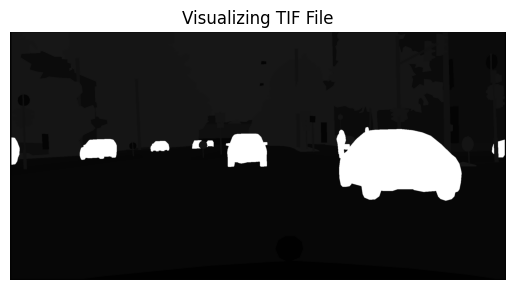

In [197]:
# Randomly select a JSON file from gtFine
if not gtBbox_Final_json_files:
    print("No JSON files found in gtFine dataset.")
else:
    sample_json = random.choice(gtBbox_Final_json_files)
    print(f"Randomly Selected JSON file: {sample_json}")
    sample_gtBbox_Final_data = parse_json_file(sample_json)

    # Derive the corresponding .tif file path in gtFinePanopticParts
    json_filename = os.path.basename(sample_json)
    tif_filename = json_filename.replace('_gtBboxCityPersons.json', '_gtFinePanopticParts.tif')

    tif_file_path = None
    for root, _, files in os.walk(gtFinePano_Final_CorePath):
        for file in files:
            if file == tif_filename:
                tif_file_path = os.path.join(root, file)
                break
        if tif_file_path:
            break

    # Visualize the .tif file if it exists
    if tif_file_path:
        print(f"Corresponding TIF file: {tif_file_path}")
        tif_image = Image.open(tif_file_path)
        plt.imshow(tif_image)
        plt.title("Visualizing TIF File")
        plt.axis('off')  # Turn off axis for better visualization
        plt.show()
    else:
        print(f"No corresponding TIF file found for {sample_json}")

In [199]:
sample_gtBbox_Final_data

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'instanceId': 24000,
   'bbox': [1454, 396, 42, 103],
   'bboxVis': [1467, 396, 16, 21],
   'label': 'pedestrian'},
  {'instanceId': 25000,
   'bbox': [1351, 406, 36, 88],
   'bboxVis': [1351, 407, 36, 87],
   'label': 'rider'},
  {'instanceId': 0,
   'bbox': [440, 441, 8, 19],
   'bboxVis': [440, 441, 8, 19],
   'label': 'ignore'},
  {'instanceId': 0,
   'bbox': [853, 447, 5, 16],
   'bboxVis': [853, 447, 5, 16],
   'label': 'ignore'}]}